# Train

In [1]:
import keras
from keras.models import load_model
from keras.models import model_from_json
from sklearn.metrics import roc_curve, auc
import numpy as np
import os
import h5py
import yaml
import pandas as pd
import matplotlib.pyplot as plt

import sys, os
sys.path.append(os.path.join(os.path.dirname(sys.path[0]),'lib'))

from train import parse_config, get_features, print_model_to_json

Using TensorFlow backend.
C:\Users\anrun\anaconda3\envs\EPE_ML\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\anrun\anaconda3\envs\EPE_ML\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\anrun\anaconda3\envs\EPE_ML\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\anrun\anaconda3\envs\EPE_ML\lib\sit

In [2]:
from keras.optimizers import Adam, Nadam
from callbacks import all_callbacks

In [33]:

from collections import namedtuple
Option = namedtuple("MyStruct", "inputModel inputFile tree config jsonModel")

options = Option(
    inputModel = '../KERAS_gru_model_weights.h5',
    inputFile = '../data/processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_withPars_truth_0.z',
    tree = 't_allpar_new',
    config = '../train/train_config_gru.yml',
    jsonModel = '../KERAS_gru_model.json'
)

print("Loading configuration from", options.config)
config = open(options.config, 'r')
yamlConfig =  yaml.load(config, Loader=yaml.FullLoader)

yamlConfig

Loading configuration from ../train/train_config_gru.yml


{'Inputs': ['j1_ptrel',
  'j1_etarot',
  'j1_phirot',
  'j1_erel',
  'j1_deltaR',
  'j1_pdgid',
  'j_index'],
 'Labels': ['j_g', 'j_q', 'j_w', 'j_z', 'j_t', 'j_index'],
 'KerasModel': 'gru_model',
 'KerasModelRetrain': 'gru_model_constraint',
 'KerasLoss': 'categorical_crossentropy',
 'L1Reg': 0.0001,
 'L1RegR': 0.001,
 'NormalizeInputs': 1,
 'InputType': 'Conv1D',
 'MaxParticles': 20}

In [34]:
X_train_val, X_test, y_train_val, y_test, labels  = get_features(options, yamlConfig)

(5131613,)
('index', 'j_ptfrac', 'j_pt', 'j_eta', 'j_mass', 'j_tau1_b1', 'j_tau2_b1', 'j_tau3_b1', 'j_tau1_b2', 'j_tau2_b2', 'j_tau3_b2', 'j_tau32_b1', 'j_tau32_b2', 'j_zlogz', 'j_c1_b0', 'j_c1_b1', 'j_c1_b2', 'j_c2_b1', 'j_c2_b2', 'j_d2_b1', 'j_d2_b2', 'j_d2_a1_b1', 'j_d2_a1_b2', 'j_m2_b1', 'j_m2_b2', 'j_n2_b1', 'j_n2_b2', 'j_tau1_b1_mmdt', 'j_tau2_b1_mmdt', 'j_tau3_b1_mmdt', 'j_tau1_b2_mmdt', 'j_tau2_b2_mmdt', 'j_tau3_b2_mmdt', 'j_tau32_b1_mmdt', 'j_tau32_b2_mmdt', 'j_c1_b0_mmdt', 'j_c1_b1_mmdt', 'j_c1_b2_mmdt', 'j_c2_b1_mmdt', 'j_c2_b2_mmdt', 'j_d2_b1_mmdt', 'j_d2_b2_mmdt', 'j_d2_a1_b1_mmdt', 'j_d2_a1_b2_mmdt', 'j_m2_b1_mmdt', 'j_m2_b2_mmdt', 'j_n2_b1_mmdt', 'j_n2_b2_mmdt', 'j_mass_trim', 'j_mass_mmdt', 'j_mass_prun', 'j_mass_sdb2', 'j_mass_sdm1', 'j_multiplicity', 'j1_px', 'j1_py', 'j1_pz', 'j1_e', 'j1_pdgid', 'j1_erel', 'j1_pt', 'j1_ptrel', 'j1_eta', 'j1_etarel', 'j1_etarot', 'j1_phi', 'j1_phirel', 'j1_phirot', 'j1_deltaR', 'j1_costheta', 'j1_costhetarel', 'j1_e1mcosthetarel', 'j_

In [25]:
json_file = open(options.jsonModel, 'r')
model = model_from_json(json_file.read())
json_file.close()

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20, 6)             0         
_________________________________________________________________
gru_selu (GRU)               (None, 20)                1620      
_________________________________________________________________
dense_relu (Dense)           (None, 20)                420       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
rnn_densef (Dense)           (None, 5)                 105       
Total params: 2,145
Trainable params: 2,145
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.load_weights(options.inputModel)
model.summary()
startlearningrate=0.0001
adam = Adam(lr=startlearningrate)
model.compile(optimizer=adam, loss=[yamlConfig['KerasLoss']], metrics=['accuracy'])

callbacks=all_callbacks(stop_patience=1000, 
                        lr_factor=0.5,
                        lr_patience=10,
                        lr_epsilon=0.000001, 
                        lr_cooldown=2, 
                        lr_minimum=0.0000001,
                        outputDir=os.curdir + '\\training_callbacks')

history = model.fit(X_train_val, y_train_val, batch_size = 1024, epochs = 100,
                validation_split = 0.25, shuffle = True, callbacks = callbacks.callbacks)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20, 6)             0         
_________________________________________________________________
gru_selu (GRU)               (None, 20)                1620      
_________________________________________________________________
dense_relu (Dense)           (None, 20)                420       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
rnn_densef (Dense)           (None, 5)                 105       
Total params: 2,145
Trainable params: 2,145
Non-trainable params: 0
_________________________________________________________________
Train on 59261 samples, validate on 19754 samples
Epoch 1/100
56320/59261 [===========================>..] - ETA: 0s - loss: 3.0059 - acc: 0

56320/59261 [===========================>..] - ETA: 0s - loss: 1.3381 - acc: 0.4827
***callbacks***
saving losses to .\training_callbacks\losses.log
Epoch 00010: val_loss improved from 1.32431 to 1.31119, saving model to .\training_callbacks/KERAS_check_best_model.h5
Epoch 00010: val_loss improved from 1.32431 to 1.31119, saving model to .\training_callbacks/KERAS_check_best_model_weights.h5
Epoch 00010: saving model to .\training_callbacks/KERAS_check_model_last.h5
Epoch 00010: saving model to .\training_callbacks/KERAS_check_model_last_weights.h5

***callbacks end***

59261/59261 [==============================] - 1s - loss: 1.3382 - acc: 0.4822 - val_loss: 1.3112 - val_acc: 0.4942
Epoch 12/100
56320/59261 [===========================>..] - ETA: 0s - loss: 1.3251 - acc: 0.4866
***callbacks***
saving losses to .\training_callbacks\losses.log
Epoch 00011: val_loss improved from 1.31119 to 1.29946, saving model to .\training_callbacks/KERAS_check_best_model.h5
Epoch 00011: val_loss impr

Epoch 00021: saving model to .\training_callbacks/KERAS_check_model_last.h5
Epoch 00021: saving model to .\training_callbacks/KERAS_check_model_last_weights.h5

***callbacks end***

59261/59261 [==============================] - 1s - loss: 1.2432 - acc: 0.5262 - val_loss: 1.2216 - val_acc: 0.5412
Epoch 23/100
56320/59261 [===========================>..] - ETA: 0s - loss: 1.2388 - acc: 0.5289
***callbacks***
saving losses to .\training_callbacks\losses.log
Epoch 00022: val_loss improved from 1.22158 to 1.21585, saving model to .\training_callbacks/KERAS_check_best_model.h5
Epoch 00022: val_loss improved from 1.22158 to 1.21585, saving model to .\training_callbacks/KERAS_check_best_model_weights.h5
Epoch 00022: saving model to .\training_callbacks/KERAS_check_model_last.h5
Epoch 00022: saving model to .\training_callbacks/KERAS_check_model_last_weights.h5

***callbacks end***

59261/59261 [==============================] - 1s - loss: 1.2364 - acc: 0.5297 - val_loss: 1.2159 - val_acc: 0.5

56320/59261 [===========================>..] - ETA: 0s - loss: 1.1894 - acc: 0.5536
***callbacks***
saving losses to .\training_callbacks\losses.log
Epoch 00033: val_loss improved from 1.17208 to 1.16813, saving model to .\training_callbacks/KERAS_check_best_model.h5
Epoch 00033: val_loss improved from 1.17208 to 1.16813, saving model to .\training_callbacks/KERAS_check_best_model_weights.h5
Epoch 00033: saving model to .\training_callbacks/KERAS_check_model_last.h5
Epoch 00033: saving model to .\training_callbacks/KERAS_check_model_last_weights.h5

***callbacks end***

59261/59261 [==============================] - 1s - loss: 1.1901 - acc: 0.5537 - val_loss: 1.1681 - val_acc: 0.5674
Epoch 35/100
56320/59261 [===========================>..] - ETA: 0s - loss: 1.1862 - acc: 0.5542
***callbacks***
saving losses to .\training_callbacks\losses.log
Epoch 00034: val_loss improved from 1.16813 to 1.16460, saving model to .\training_callbacks/KERAS_check_best_model.h5
Epoch 00034: val_loss impr

Epoch 00044: saving model to .\training_callbacks/KERAS_check_model_last.h5
Epoch 00044: saving model to .\training_callbacks/KERAS_check_model_last_weights.h5

***callbacks end***

59261/59261 [==============================] - 1s - loss: 1.1551 - acc: 0.5698 - val_loss: 1.1319 - val_acc: 0.5816
Epoch 46/100
56320/59261 [===========================>..] - ETA: 0s - loss: 1.1532 - acc: 0.5704
***callbacks***
saving losses to .\training_callbacks\losses.log
Epoch 00045: val_loss improved from 1.13192 to 1.12890, saving model to .\training_callbacks/KERAS_check_best_model.h5
Epoch 00045: val_loss improved from 1.13192 to 1.12890, saving model to .\training_callbacks/KERAS_check_best_model_weights.h5
Epoch 00045: saving model to .\training_callbacks/KERAS_check_model_last.h5
Epoch 00045: saving model to .\training_callbacks/KERAS_check_model_last_weights.h5

***callbacks end***

59261/59261 [==============================] - 1s - loss: 1.1524 - acc: 0.5703 - val_loss: 1.1289 - val_acc: 0.5

56320/59261 [===========================>..] - ETA: 0s - loss: 1.1249 - acc: 0.5856
***callbacks***
saving losses to .\training_callbacks\losses.log
Epoch 00056: val_loss improved from 1.10441 to 1.10260, saving model to .\training_callbacks/KERAS_check_best_model.h5
Epoch 00056: val_loss improved from 1.10441 to 1.10260, saving model to .\training_callbacks/KERAS_check_best_model_weights.h5
Epoch 00056: saving model to .\training_callbacks/KERAS_check_model_last.h5
Epoch 00056: saving model to .\training_callbacks/KERAS_check_model_last_weights.h5

***callbacks end***

59261/59261 [==============================] - 1s - loss: 1.1252 - acc: 0.5856 - val_loss: 1.1026 - val_acc: 0.5969
Epoch 58/100
58368/59261 [============================>.] - ETA: 0s - loss: 1.1242 - acc: 0.5854
***callbacks***
saving losses to .\training_callbacks\losses.log
Epoch 00057: val_loss improved from 1.10260 to 1.10032, saving model to .\training_callbacks/KERAS_check_best_model.h5
Epoch 00057: val_loss impr

Epoch 00067: saving model to .\training_callbacks/KERAS_check_model_last.h5
Epoch 00067: saving model to .\training_callbacks/KERAS_check_model_last_weights.h5

***callbacks end***

59261/59261 [==============================] - 1s - loss: 1.1043 - acc: 0.5986 - val_loss: 1.0812 - val_acc: 0.6085
Epoch 69/100
56320/59261 [===========================>..] - ETA: 0s - loss: 1.1020 - acc: 0.5973
***callbacks***
saving losses to .\training_callbacks\losses.log
Epoch 00068: val_loss improved from 1.08116 to 1.07945, saving model to .\training_callbacks/KERAS_check_best_model.h5
Epoch 00068: val_loss improved from 1.08116 to 1.07945, saving model to .\training_callbacks/KERAS_check_best_model_weights.h5
Epoch 00068: saving model to .\training_callbacks/KERAS_check_model_last.h5
Epoch 00068: saving model to .\training_callbacks/KERAS_check_model_last_weights.h5

***callbacks end***

59261/59261 [==============================] - 1s - loss: 1.1013 - acc: 0.5981 - val_loss: 1.0794 - val_acc: 0.6

56320/59261 [===========================>..] - ETA: 0s - loss: 1.0859 - acc: 0.6081
***callbacks***
saving losses to .\training_callbacks\losses.log
Epoch 00079: val_loss improved from 1.06290 to 1.06118, saving model to .\training_callbacks/KERAS_check_best_model.h5
Epoch 00079: val_loss improved from 1.06290 to 1.06118, saving model to .\training_callbacks/KERAS_check_best_model_weights.h5
Epoch 00079: saving model to .\training_callbacks/KERAS_check_model_last.h5
Epoch 00079: saving model to .\training_callbacks/KERAS_check_model_last_weights.h5
Epoch 00079: saving model to .\training_callbacks/KERAS_check_model_epoch79.h5

***callbacks end***

59261/59261 [==============================] - 1s - loss: 1.0850 - acc: 0.6077 - val_loss: 1.0612 - val_acc: 0.6225
Epoch 81/100
56320/59261 [===========================>..] - ETA: 0s - loss: 1.0842 - acc: 0.6111
***callbacks***
saving losses to .\training_callbacks\losses.log
Epoch 00080: val_loss improved from 1.06118 to 1.05975, saving mod

Epoch 00090: val_loss improved from 1.04543 to 1.04434, saving model to .\training_callbacks/KERAS_check_best_model_weights.h5
Epoch 00090: saving model to .\training_callbacks/KERAS_check_model_last.h5
Epoch 00090: saving model to .\training_callbacks/KERAS_check_model_last_weights.h5

***callbacks end***

59261/59261 [==============================] - 1s - loss: 1.0691 - acc: 0.6212 - val_loss: 1.0443 - val_acc: 0.6341
Epoch 92/100
56320/59261 [===========================>..] - ETA: 0s - loss: 1.0666 - acc: 0.6225
***callbacks***
saving losses to .\training_callbacks\losses.log
Epoch 00091: val_loss improved from 1.04434 to 1.04253, saving model to .\training_callbacks/KERAS_check_best_model.h5
Epoch 00091: val_loss improved from 1.04434 to 1.04253, saving model to .\training_callbacks/KERAS_check_best_model_weights.h5
Epoch 00091: saving model to .\training_callbacks/KERAS_check_model_last.h5
Epoch 00091: saving model to .\training_callbacks/KERAS_check_model_last_weights.h5

***cal

# Eval

In [36]:
def makeRoc(features_val, labels, labels_val, model):
    print('in makeRoc()')
    if 'j_index' in labels: labels.remove('j_index')

    predict_test = model.predict(features_val)

    df = pd.DataFrame()
    
    fpr = {}
    tpr = {}
    auc1 = {}
    
    plt.figure()       
    for i, label in enumerate(labels):
        df[label] = labels_val[:,i]
        df[label + '_pred'] = predict_test[:,i]
        
        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

        auc1[label] = auc(fpr[label], tpr[label])
            
        plt.plot(tpr[label],fpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
    plt.semilogy()
    plt.xlabel("Signal Efficiency")
    plt.ylabel("Background Efficiency")
    plt.ylim(0.001,1)
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.figtext(0.25, 0.90,'hls4ml',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    plt.savefig("mygraph.png")
#     plt.savefig('%s/ROC.pdf'%(options.outputDir))
#     plt.savefig('%s/ROC.pdf' %(outputDir))
    return predict_test

Plot ROC curve
in makeRoc()


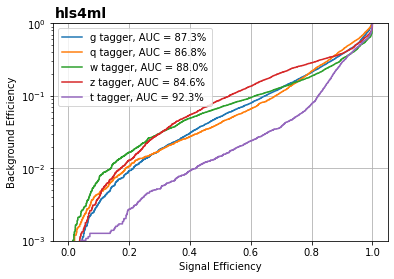

In [37]:
print("Plot ROC curve")
y_predict = makeRoc(X_test, labels, y_test, model)

In [38]:
def learningCurve(history):
    plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'], linewidth=1)
    plt.plot(history.history['val_loss'], linewidth=1)
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['training sample loss','validation sample loss'])
    plt.savefig('Learning_curve.pdf')
    plt.show()
    plt.close()

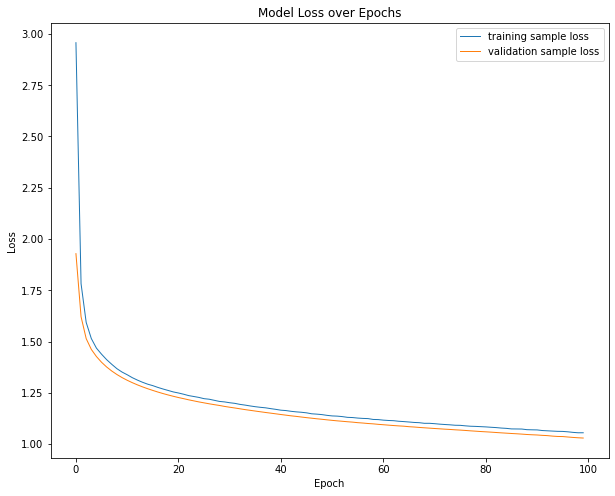

In [39]:
learningCurve(history)